# PROJET : Anticiper les besoins en consommation électrique de bâtiments

**Autor** : Louis BIRENHOLZ   
**Date** : 12/03/2020  
**Durée totale (3 notebooks)** : 100 heures  
**Vidéo du projet :** https://www.youtube.com/watch?v=GRcUu2_YbFE&feature=emb_title

## Partie 3 : Modélisation et comparaison des algos

L'objectif est de comparer les **RMSE**, **MAPE** et **temps d'éxecution** de chaque algo que nous allons tester pour au final choisir celui qui convient le mieux pour notre problème.

On testera aussi l'impact de la variable **ENERGYSTARScore** sur la prédiction de **l'émission de CO2**

Les **algos** que nous allons tester sont : 
    - Une approche naïve
    - Le KNN (KNeighborsRegressor)
    - Une régression simple 
    - Elastic Net
    - SVR
    - Random Forest Regressor
    - Gradient Boosting Tree Regressor

## Objectifs : 

On souhaite prédire les **émissions de CO2** et la **consommation totale d’énergie** des bâtiments pour lesquels elles n’ont pas encore été mesurées.

### Librairies 

In [1]:
# Classic lib.
import pandas as pd
import numpy as np

# Viz lib.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Other.
import math
from random import *
import statistics 
import timeit

In [2]:
# ML.
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Error & Metrics.
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

### Data

In [3]:
%%time

# Read data.
df = pd.read_csv(r'C:\Users\Louis\Projet 4\df_clean.csv', sep='\t')
df.drop(['Unnamed: 0'],axis=1,inplace = True)

Wall time: 39.9 ms


In [4]:
df.head()

,OSEBuildingID,DataYear,PropertyGFATotal,YearBuilt,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,GHGEmissions(MetricTonsCO2e),SiteEnergyUse(kBtu),...,Large Office,Non-Refrigerated Warehouse,Retail Store,NonResidential,Others BuildingType,Others Neighborhood,DOWNTOWN,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE
0,1,2015,88434,1927,12.0,65.0,47.612190,-122.337997,249.43,6981428.0,...,0,0,0,1,0,0,1,0,0,0
1,2,2015,103566,1996,11.0,51.0,47.613106,-122.333358,263.51,8354235.0,...,0,0,0,1,0,0,1,0,0,0
2,3,2015,961990,1969,41.0,18.0,47.613349,-122.337699,2061.48,73130656.0,...,0,0,0,1,0,0,1,0,0,0
3,8,2015,119890,1980,18.0,67.0,47.613754,-122.340924,507.70,14829099.0,...,0,0,0,1,0,0,1,0,0,0
4,10,2015,83008,1926,11.0,25.0,47.614114,-122.332741,208.46,6252842.0,...,0,0,0,1,0,0,1,0,0,0


### Settings

In [5]:
# Style.
plt.style.use('ggplot')
sns.set_style("darkgrid")

# Options.
pd.options.display.max_columns = 50

In [6]:
# Drop some useless feature.

df.drop(['OSEBuildingID','DataYear'], axis=1, inplace = True)

# Avec ENERGYSTARScore.
Col1 = list(set(df.columns) - set(['GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)']))

# Sans ENERGYSTARScore.
Col2 = list(set(df.columns) - set(['GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)', 'ENERGYSTARScore']))

In [7]:
df.head()

,PropertyGFATotal,YearBuilt,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,GHGEmissions(MetricTonsCO2e),SiteEnergyUse(kBtu),Others PrimaryPropertyType,Small- and Mid-Sized Office,Large Office,Non-Refrigerated Warehouse,Retail Store,NonResidential,Others BuildingType,Others Neighborhood,DOWNTOWN,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE
0,88434,1927,12.0,65.0,47.612190,-122.337997,249.43,6981428.0,1,0,0,0,0,1,0,0,1,0,0,0
1,103566,1996,11.0,51.0,47.613106,-122.333358,263.51,8354235.0,1,0,0,0,0,1,0,0,1,0,0,0
2,961990,1969,41.0,18.0,47.613349,-122.337699,2061.48,73130656.0,1,0,0,0,0,1,0,0,1,0,0,0
3,119890,1980,18.0,67.0,47.613754,-122.340924,507.70,14829099.0,1,0,0,0,0,1,0,0,1,0,0,0
4,83008,1926,11.0,25.0,47.614114,-122.332741,208.46,6252842.0,1,0,0,0,0,1,0,0,1,0,0,0


## Passage au log sur les targets

On passe au log nos targets pour s'approcher d'une **distribution Gausienne**

In [8]:
# Destuction des lignes ou on a des targets à 0 (pour le passage au log).
mask1 = (df['GHGEmissions(MetricTonsCO2e)'] != 0)
mask2 = (df['SiteEnergyUse(kBtu)'] != 0)
df = df[mask1 & mask2]

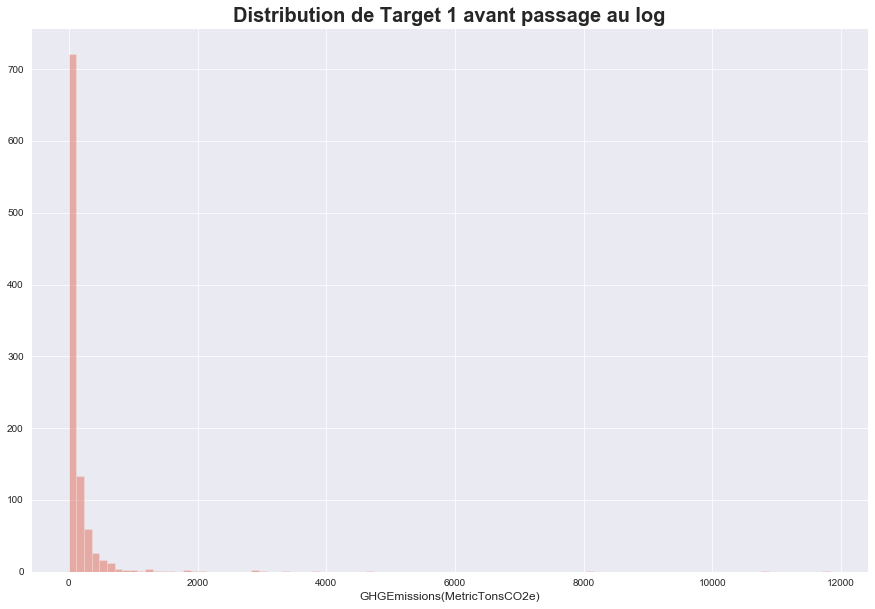

In [9]:
fig = plt.figure(figsize=(15,10))
plt.title("Distribution de Target 1 avant passage au log", weight = 'bold',size=20)
sns.distplot(df['GHGEmissions(MetricTonsCO2e)'],bins=100, kde=False)

In [10]:
# Passage au log.
df['GHGEmissions(MetricTonsCO2e)'] = df['GHGEmissions(MetricTonsCO2e)'].apply(lambda x : math.log(x)) 
df['SiteEnergyUse(kBtu)'] = df['SiteEnergyUse(kBtu)'].apply(lambda x : math.log(x)) 

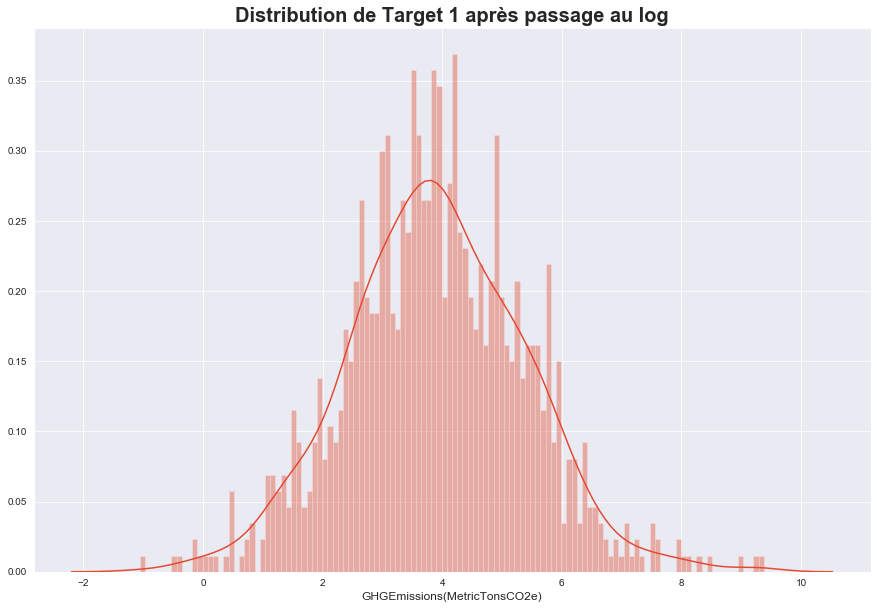

In [11]:
fig = plt.figure(figsize=(15,10))
plt.title("Distribution de Target 1 après passage au log", weight = 'bold',size=20)
sns.distplot(df['GHGEmissions(MetricTonsCO2e)'],bins=120)

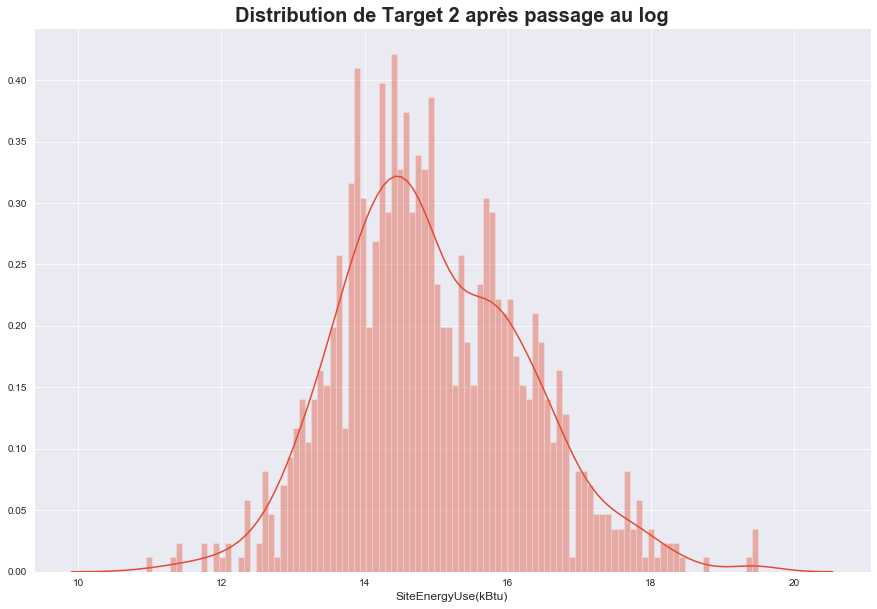

In [12]:
fig = plt.figure(figsize=(15,10))
plt.title("Distribution de Target 2 après passage au log", weight = 'bold',size=20)
sns.distplot(df['SiteEnergyUse(kBtu)'],bins=100)

## Préparation pour test des modèles

In [13]:
# Target 1.
'GHGEmissions(MetricTonsCO2e)' #Emission de CO2
target1_Emissions = df['GHGEmissions(MetricTonsCO2e)']

# Target 2.
'SiteEnergyUse(kBtu)' #Utilisation d'énergie du site considéré (en kBtu = British thermal unit), 1 kWh x 3.412 = 3.412 kBtu
target2_EnergyUse = df['SiteEnergyUse(kBtu)']

In [14]:
# Split sur target 1. 
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df[Col1],target1_Emissions, test_size = 0.25) #Avec ENERGYSTARScore
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df[Col2],target1_Emissions, test_size = 0.25) #Sans ENERGYSTARScore

# Split sur target 2.
X_train11, X_test11, Y_train11, Y_test11 = train_test_split(df[Col1], target2_EnergyUse, test_size = 0.25) #Avec ENERGYSTARScore

In [15]:
# Standardisation du jeu d'entrainement et de test (Target1).

scaler1 = StandardScaler().fit(X_train1)
X_train1_std = pd.DataFrame(scaler1.transform(X_train1), columns = X_train1.columns)
X_test1_std = scaler1.transform(X_test1)

scaler2 = StandardScaler().fit(X_train2)
X_train2_std = pd.DataFrame(scaler2.transform(X_train2), columns = X_train2.columns)
X_test2_std = scaler2.transform(X_test2)

In [16]:
# Standardisation du jeu d'entrainement et de test (Target2).

scaler3 = StandardScaler().fit(X_train11)
X_train11_std = pd.DataFrame(scaler3.transform(X_train11), columns = X_train11.columns)
X_test11_std = scaler3.transform(X_test11)

# Tests des modèles

In [17]:
def Visualisation(Y_test,y_test_pred, error,name):
    
    """
    Cette fonction permet de faire une visualisation entre le vrai score et la prédiciton
    
    """

    fig = plt.figure(figsize=(15, 10))
    sizes = {}
    for (yt, yp) in zip(list(Y_test), list(y_test_pred)):
        if (yt, yp) in sizes.keys():
            sizes[(yt, yp)] += 1
        else:
            sizes[(yt, yp)] = 1        
    keys = sizes.keys()

    # afficher les prédictions
    plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], alpha=0.3,color='b',
             s=14, 
            label="gamma = 0.01: RMSE = {:.2f}".format(error))
    
    plt.plot([-1,10],[-1,10],color = 'green', linestyle = 'dashed', linewidth = 1.4)

    # étiqueter les axes et le graphique
    plt.xlabel('Vrai score', fontsize=16)
    plt.ylabel('Prédiction', fontsize=16)
    plt.title(name, fontsize=20, weight='bold')

    # limites des axes
    plt.xlim([-1, 10])
    plt.ylim([-0.5, 8])

    # afficher la légende
    plt.legend(loc="lower right", fontsize=12)

In [18]:
# Fonction renvoyant la MAPE (mean absolute percentage error).

def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.mean(np.abs((y_true - y_pred) / y_true))*100)

### Création des listes d'erreur (RMSE/MAPE/Time) pour comparaison des algos

In [19]:
List_RMSE1 = [] # Avec EnergyStarScore
List_RMSE2 = [] # Sans EnergyStarScore

List_MAPE1 = [] # Avec EnergyStarScore
List_MAPE2 = [] # Sans EnergyStarScore

List_RMSE1_target2 = [] # Avec EnergyStarScore

List_MAPE1_target2 = [] # Avec EnergyStarScore

List_time = [] # Liste ou on récuperera les temps d'executions des algos testés.

List_model = ['Approche naïve', 'KNeighborsRegressor', 
              'Baseline Regression', 'Elastic Net', 'SVR', 
              'Random Forest', 'Gradient Boosting'] # Liste des différent algos testés.

# Avec EnergyStarScore (pour Target 1)

On rappelle que **Target 1** est **GHGEmissions(MetricTonsCO2e)**

## Approche naïve

In [20]:
# Création d'un vecteur de valeurs aléatoires comprises entre np.min(Y_train) et np.max(Y_train).
y_pred_random=[] 

for i in range(0,Y_test1.shape[0]):
    y = uniform(np.min(Y_train1), np.max(Y_train1))
    y_pred_random.append(y)

In [21]:
naive_error_rmse = np.sqrt(metrics.mean_squared_error(Y_test1, y_pred_random))
naive_error_mape = mean_absolute_percentage_error(Y_test1, y_pred_random)

print('RMSE :', naive_error_rmse)
print( 'MAPE : ' , naive_error_mape)

List_RMSE1.append(naive_error_rmse)
List_RMSE2.append(naive_error_rmse)

List_MAPE1.append(naive_error_mape)
List_MAPE2.append(naive_error_mape)

RMSE : 3.225251135746342
MAPE :  90.23654648180704


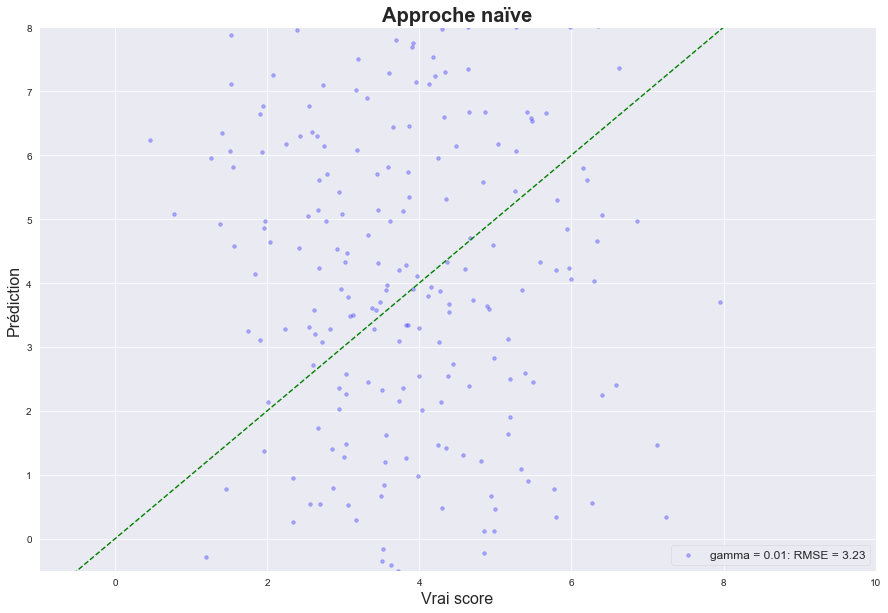

In [22]:
Visualisation(Y_test1,y_pred_random, naive_error_rmse,'Approche naïve')

## KNeighborsRegressor 

In [23]:
start_time = timeit.default_timer()

knn = KNeighborsRegressor()
grid = GridSearchCV(knn, {'n_neighbors' : list(range(1,30))}, cv = 5, scoring = 'neg_mean_squared_error')

grid.fit(X_train1_std, Y_train1)

elapsed = timeit.default_timer() - start_time

In [24]:
k = []
w = grid.best_estimator_.predict(X_test1_std)
for i in w:
    k.append(math.exp(i))

In [25]:
np.sqrt(metrics.mean_squared_error(Y_test1.apply(lambda x : math.exp(x)), k))

200.93698747283705

In [26]:
mean_absolute_percentage_error(Y_test1.apply(lambda x : math.exp(x)), k)

165.52891193502484

In [27]:
print(grid.best_params_)
List_time.append(elapsed)

{'n_neighbors': 6}


In [28]:
knn_error_rmse = np.sqrt(metrics.mean_squared_error(Y_test1, grid.best_estimator_.predict(X_test1_std)))
knn_mape = mean_absolute_percentage_error(Y_test1, grid.best_estimator_.predict(X_test1_std))

print("RMSE (KNN):" , knn_error_rmse)
print("MAPE (KNN)" , knn_mape)

List_RMSE1.append(knn_error_rmse)
List_MAPE1.append(knn_mape)

RMSE (KNN): 1.181769762642157
MAPE (KNN) 34.221636325508385


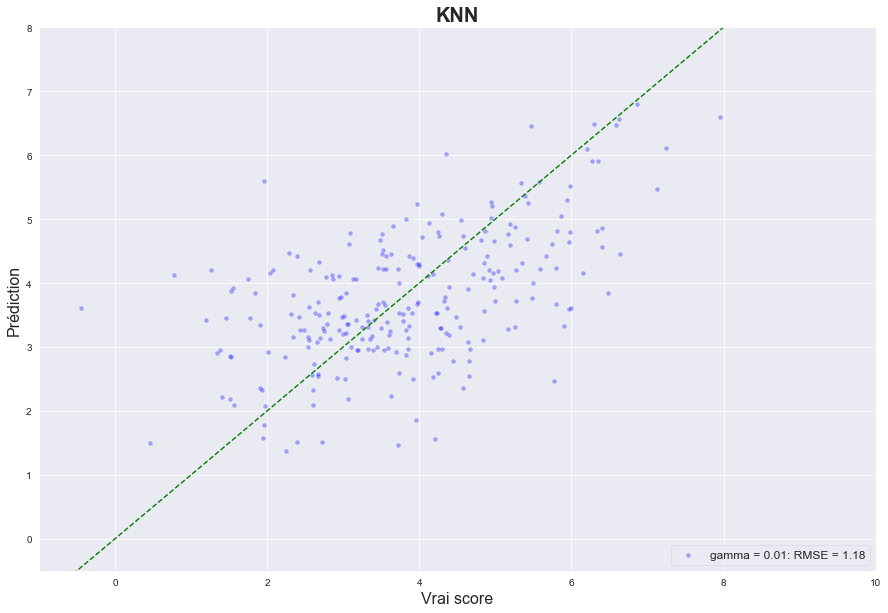

In [29]:
Visualisation(Y_test1, grid.best_estimator_.predict(X_test1_std), knn_error_rmse,'KNN')

## Baseline Regression

In [30]:
start_time = timeit.default_timer()

linear = linear_model.LinearRegression()
linear.fit(X_train1_std,Y_train1)
baseline_error = np.mean(sklearn.model_selection.cross_val_score(linear,X_train1_std,Y_train1,cv=5, scoring=make_scorer(mean_squared_error)))

elapsed = timeit.default_timer() - start_time

In [31]:
print( "Baseline error (RMSE) :",baseline_error)
print("Baseline error (MAPE) :", mean_absolute_percentage_error(Y_test1, linear.predict(X_test1_std)))

List_RMSE1.append(baseline_error)
List_MAPE1.append(mean_absolute_percentage_error(Y_test1, linear.predict(X_test1_std)))
List_time.append(elapsed)

Baseline error (RMSE) : 1.363131150609687
Baseline error (MAPE) : 32.66287940392794


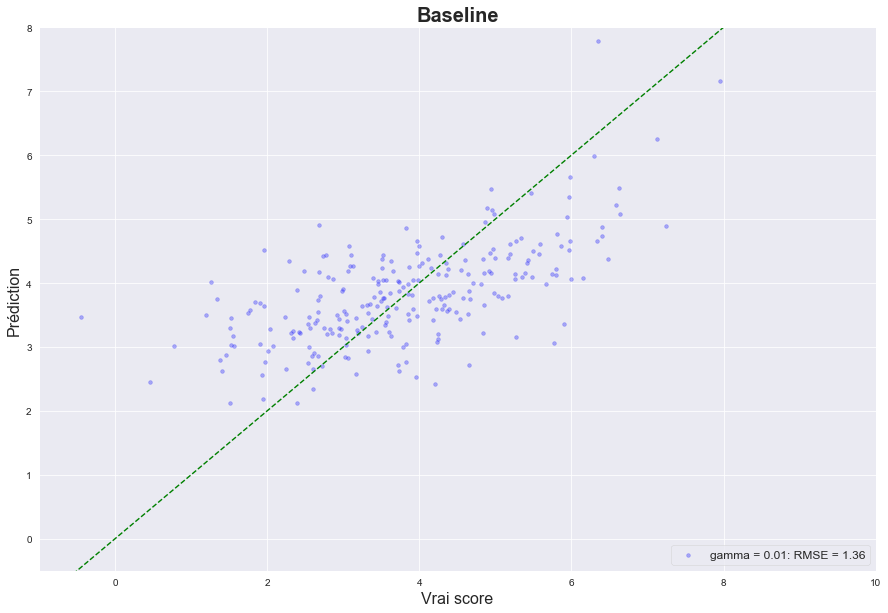

In [32]:
Visualisation(Y_test1,linear.predict(X_test1_std),baseline_error, 'Baseline')

## Elastic Net 

In [33]:
start_time = timeit.default_timer()

elastic = linear_model.ElasticNet()
grid_elastic = GridSearchCV(elastic, {'alpha' : np.arange(0,10,1), 'l1_ratio' : np.arange(0,1,0.1) }, 
                            cv = 5, scoring = 'neg_mean_squared_error')
grid_elastic.fit(X_train1_std, Y_train1)

elapsed = timeit.default_timer() - start_time

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.91457304188447, tolerance: 0.14132437144868265
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.665488813641, tolerance: 0.1364578055124109
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.0341402890749, tolerance: 0.13191618883479392
  pos

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.3687172999234, tolerance: 0.13361860235621076
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\U

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.665488813641, tolerance: 0.1364578055124109
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Use

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.768617484582, tolerance: 0.14132437144868265
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.2995105630553, tolerance: 0.1364578055124109
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.3690647548965, tolerance: 0.13191618883479392
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

In [34]:
print(grid_elastic.best_params_)
List_time.append(elapsed)

{'alpha': 0, 'l1_ratio': 0.0}


In [35]:
elastic_error = np.sqrt(metrics.mean_squared_error(Y_test1, grid_elastic.best_estimator_.predict(X_test1_std)))
elastic_mape = mean_absolute_percentage_error(Y_test1,  grid_elastic.best_estimator_.predict(X_test1_std))

print("RMSE (ElasticNet) :", elastic_error)
print("MAPE(ElasticNet) :", elastic_mape)

List_RMSE1.append(elastic_error)
List_MAPE1.append(elastic_mape)

RMSE (ElasticNet) : 1.0834555101450691
MAPE(ElasticNet) : 32.662879403927924


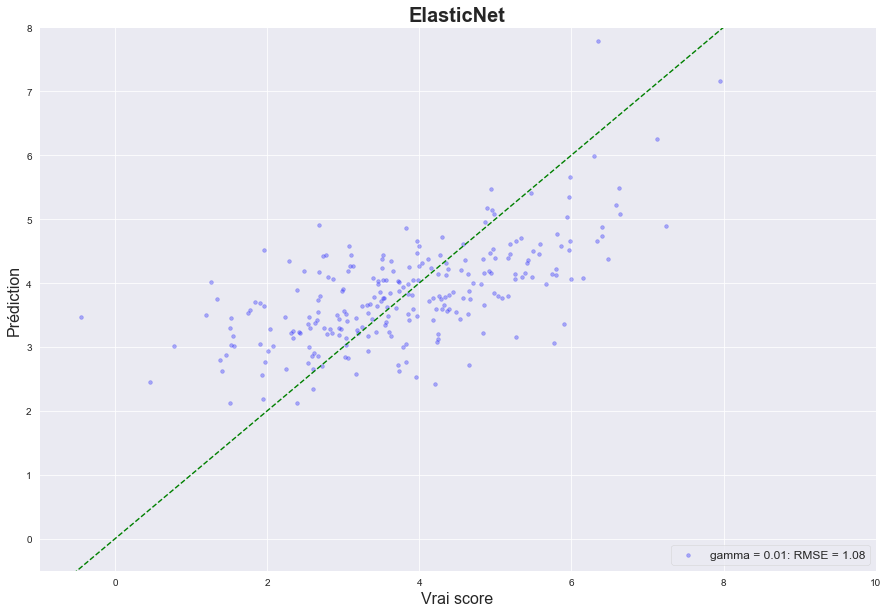

In [36]:
Visualisation(Y_test1, grid_elastic.best_estimator_.predict(X_test1_std), elastic_error, 'ElasticNet')

## SVR (Epsilon-Support Vector Regression)

In [37]:
start_time = timeit.default_timer()

svr = SVR()
grid3 = GridSearchCV(svr, {'C' : np.arange(1,100,5), 'epsilon' : np.arange(0,1,0.1) }, cv = 5, 
                     scoring= 'neg_mean_squared_error')
grid3.fit(X_train1_std, Y_train1)

elapsed = timeit.default_timer() - start_time

In [38]:
grid3.best_params_
List_time.append(elapsed)

In [39]:
svr_error = np.sqrt(metrics.mean_squared_error(Y_test1, grid3.best_estimator_.predict(X_test1_std)))
svr_mape = mean_absolute_percentage_error(Y_test1,  grid3.best_estimator_.predict(X_test1_std))

print("RMSE (SVR) :" , svr_error)
print("MAPE (SVR) :", svr_mape)

List_RMSE1.append(svr_error)
List_MAPE1.append(svr_mape)

RMSE (SVR) : 1.0347651254763572
MAPE (SVR) : 32.285238512631906


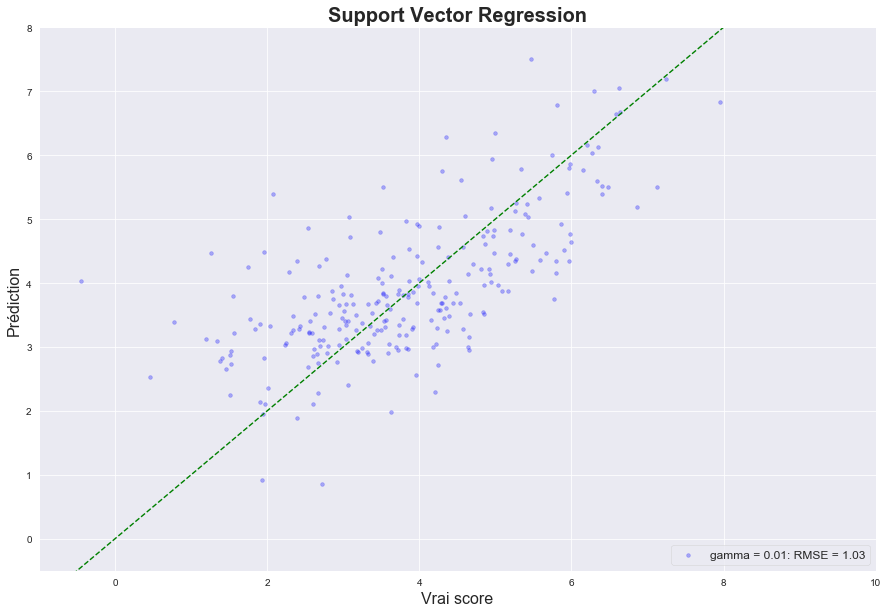

In [40]:
Visualisation(Y_test1, grid3.best_estimator_.predict(X_test1_std),svr_error, 'Support Vector Regression')

## Random Forest Regressor

In [41]:
start_time = timeit.default_timer()

forest_regr = RandomForestRegressor()
grid4 = GridSearchCV(forest_regr, {'max_depth': range(3,7), 'n_estimators': (200, 300, 500, 600)}, 
        cv=5, scoring='neg_mean_squared_error', verbose=0)

grid4.fit(X_train1_std, Y_train1)

elapsed = timeit.default_timer() - start_time

grid4.best_params_            

{'max_depth': 6, 'n_estimators': 600}

In [42]:
List_time.append(elapsed)

In [43]:
forest_error = np.sqrt(metrics.mean_squared_error(Y_test1, grid4.best_estimator_.predict(X_test1_std)))
forest_mape = mean_absolute_percentage_error(Y_test1,  grid4.best_estimator_.predict(X_test1_std))

print("RMSE (Random Forest Regressor) :" , forest_error)
print("MAPE (Random Forest Regressor) :", forest_mape)

List_RMSE1.append(forest_error)
List_MAPE1.append(forest_mape)

RMSE (Random Forest Regressor) : 0.8908170314420452
MAPE (Random Forest Regressor) : 26.003965355620963


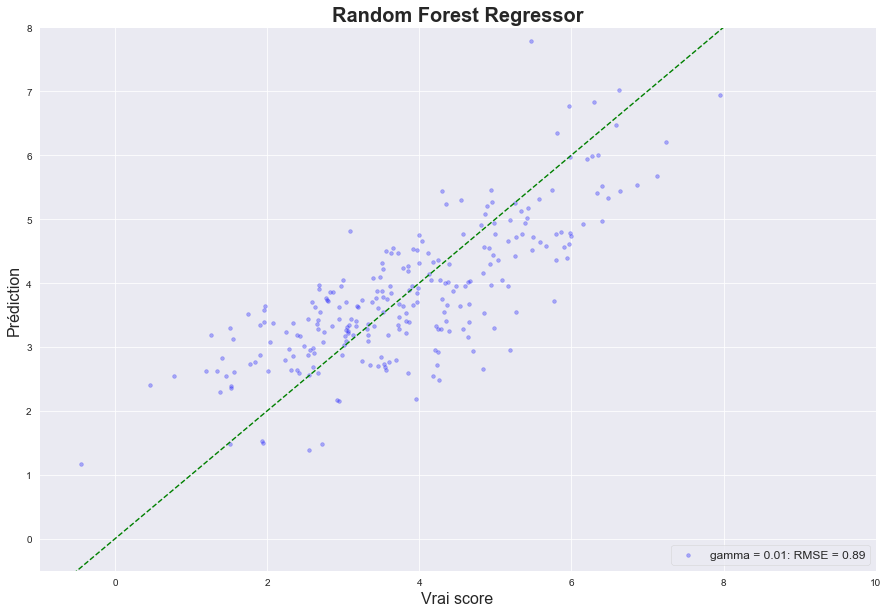

In [44]:
Visualisation(Y_test1, grid4.best_estimator_.predict(X_test1_std),forest_error, 'Random Forest Regressor')

## Gradient Boosting Regressor

In [45]:
start_time = timeit.default_timer()

regressor = GradientBoostingRegressor()

grid5 = GridSearchCV(regressor, {'max_depth': range(4,7), 'n_estimators': (50, 60 , 80, 100, 250),
                     'learning_rate': np.arange(0.05,0.5,0.05)}, cv=5, scoring='neg_mean_squared_error', verbose=0)

grid5.fit(X_train1_std,Y_train1)

elapsed = timeit.default_timer() - start_time

In [46]:
print(grid5.best_params_)
List_time.append(elapsed)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80}


In [47]:
boosting_error = np.sqrt(metrics.mean_squared_error(Y_test1, grid5.best_estimator_.predict(X_test1_std)))
boosting_mape = mean_absolute_percentage_error(Y_test1,  grid5.best_estimator_.predict(X_test1_std))

print( "RMSE :", boosting_error)
print("MAPE :", boosting_mape)

List_RMSE1.append(boosting_error)
List_MAPE1.append(boosting_mape)

RMSE : 0.91712719414447
MAPE : 25.483888164677193


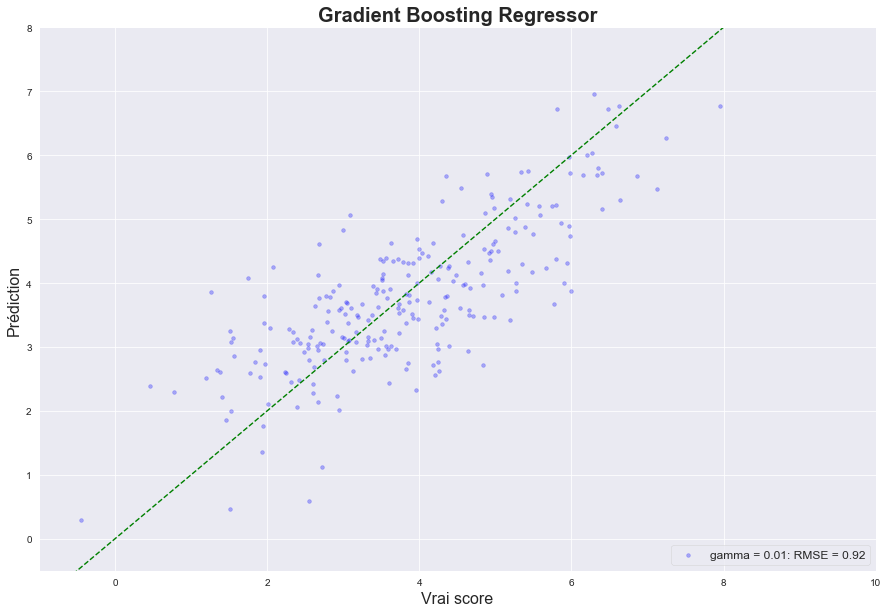

In [48]:
Visualisation(Y_test1, grid5.best_estimator_.predict(X_test1_std),boosting_error, 'Gradient Boosting Regressor')

# Sans EnergyStarScore (Pour Target 1)

On refait pareil en enlevant la variable **EnergyStarScore**

## KNeighborsRegressor 

In [49]:
knn2 = KNeighborsRegressor()
grid = GridSearchCV(knn2, {'n_neighbors' : list(range(1,30))}, cv = 5, scoring= 'neg_mean_squared_error')
grid.fit(X_train2_std, Y_train2)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [50]:
grid.best_params_

{'n_neighbors': 7}

In [51]:
knn_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, grid.best_estimator_.predict(X_test2_std)))
knn_mape2 = mean_absolute_percentage_error(Y_test2,  grid.best_estimator_.predict(X_test2_std))

print("Knn Error (RMSE) :", knn_error2)
print("MAPE :", knn_mape2)

List_RMSE2.append(knn_error2)
List_MAPE2.append(knn_mape2)

Knn Error (RMSE) : 1.1520542697142755
MAPE : 52.88905295498485


## Baseline (Regression)

In [52]:
linear = linear_model.LinearRegression()
linear.fit(X_train2_std,Y_train2)

baseline_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, linear.predict(X_test2_std)))

print("Baseline error (RMSE) :",baseline_error2)
print("MAPE :", mean_absolute_percentage_error(Y_test2,  linear.predict(X_test2_std)))

List_RMSE2.append(baseline_error2)
List_MAPE2.append(mean_absolute_percentage_error(Y_test2,  linear.predict(X_test2_std)))

Baseline error (RMSE) : 1.131836091102242
MAPE : 52.12929148555555


## Elastic Net

In [53]:
elastic = linear_model.ElasticNet()
grid_elastic = GridSearchCV(elastic, {'alpha' : np.arange(0,10,1), 'l1_ratio' : np.arange(0,1,0.1) }, 
                            cv = 5, scoring = 'neg_mean_squared_error')
grid_elastic.fit(X_train2_std, Y_train2)

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394.26549791171465, tolerance: 0.1271577234129936
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\U

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.8925706135351, tolerance: 0.13193681550215075
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\skle

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394.26549791171465, tolerance: 0.1271577234129936
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\skle

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4016988188985, tolerance: 0.1271577234129936
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.5249906788191, tolerance: 0.13526302893542586
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.4247783490636, tolerance: 0.13193681550215075
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591.9642564283845, tolerance: 0.1271577234129936
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623.346248648258, tolerance: 0.13526302893542586
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.6701065038286, tolerance: 0.13193681550215075
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [54]:
grid_elastic.best_params_

{'alpha': 0, 'l1_ratio': 0.0}

In [55]:
elastic_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, grid_elastic.best_estimator_.predict(X_test2_std)))
elastic_mape2 = mean_absolute_percentage_error(Y_test2,  grid_elastic.best_estimator_.predict(X_test2_std))

print("ElasticNet error (RMSE) :", elastic_error2)
print("MAPE :", elastic_mape2)

List_RMSE2.append(elastic_error2)
List_MAPE2.append(elastic_mape2)

ElasticNet error (RMSE) : 1.131836091102242
MAPE : 52.129291485555584


## SVR (Epsilon-Support Vector Regression)

In [56]:
svr = SVR()
grid3 = GridSearchCV(svr, {'C' : np.arange(1,20,1), 'epsilon' : np.arange(0,1,0.1) }, 
                     cv = 5, scoring= 'neg_mean_squared_error')
grid3.fit(X_train2_std, Y_train2)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'epsilon': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [57]:
grid3.best_params_

{'C': 7, 'epsilon': 0.7000000000000001}

In [58]:
SVR_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, grid3.best_estimator_.predict(X_test2_std)))
SVR_mape2 = mean_absolute_percentage_error(Y_test2,  grid3.best_estimator_.predict(X_test2_std))

print("SVR (RMSE) :", SVR_error2)

List_RMSE2.append(SVR_error2)
List_MAPE2.append(SVR_mape2)

SVR (RMSE) : 1.0776987112091652


## Random Forest Regression 

In [59]:
forest_regr = RandomForestRegressor()
grid4 = GridSearchCV(forest_regr, {'max_depth': range(3,7), 'n_estimators': (200, 300, 500, 600)}, 
        cv=5, scoring='neg_mean_squared_error', verbose=0)

grid4.fit(X_train2_std, Y_train2)

grid4.best_params_   

{'max_depth': 6, 'n_estimators': 200}

In [60]:
forest_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, grid4.best_estimator_.predict(X_test2_std)))
forest_mape2 = mean_absolute_percentage_error(Y_test2,  grid4.best_estimator_.predict(X_test2_std))

print("Random Forest (RMSE) :",forest_error2)

List_RMSE2.append(forest_error2)
List_MAPE2.append(forest_mape2)

Random Forest (RMSE) : 1.073008442771248


## Gradient Boosting

In [61]:
regressor = GradientBoostingRegressor()

grid5 = GridSearchCV(regressor, {'max_depth': range(4,7), 'n_estimators': (50, 60 , 80, 100),
                     'learning_rate': np.arange(0.05,0.5,0.05) }, cv=5, scoring='neg_mean_squared_error', verbose=0)

grid5.fit(X_train2_std,Y_train2)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [62]:
boosting_error2 = np.sqrt(metrics.mean_squared_error(Y_test2, grid5.best_estimator_.predict(X_test2_std)))
boosting_mape2 = mean_absolute_percentage_error(Y_test2,  grid5.best_estimator_.predict(X_test2_std))

List_RMSE2.append(boosting_error2)
List_MAPE2.append(boosting_mape2)

# Comparatif (Target1)

<BarContainer object of 6 artists>

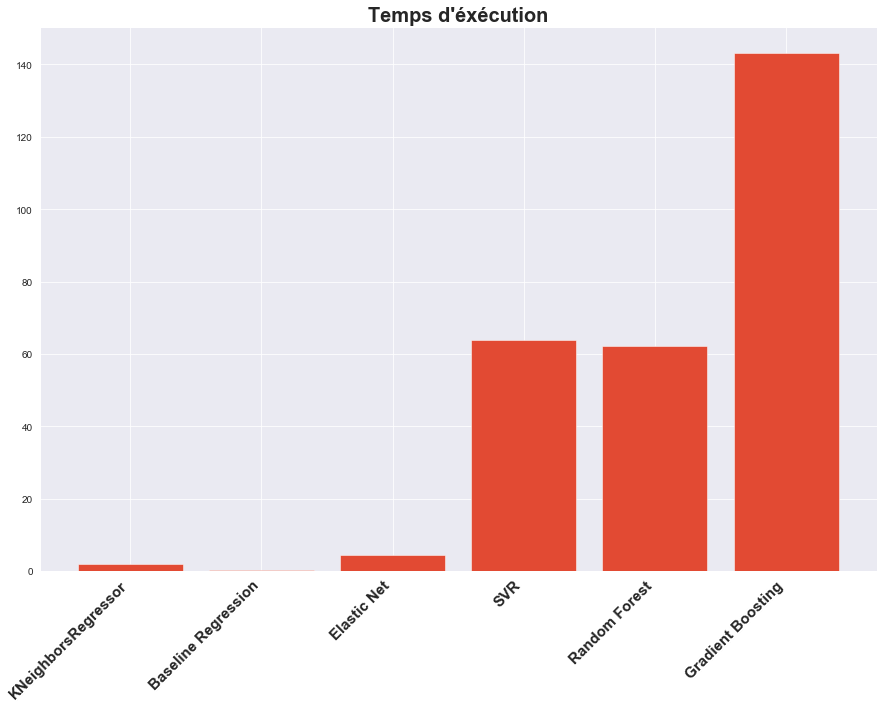

In [63]:
plt.figure(figsize=(15,10))
plt.title("Temps d'éxécution",size = 20, weight = 'bold')
plt.xticks(range(len(List_time)),['KNeighborsRegressor','Baseline Regression','Elastic Net',
                                  'SVR','Random Forest','Gradient Boosting'], rotation = 45, 
           ha = 'right', size = 15, weight = 'bold')
plt.bar(range(len(List_time)),List_time)

([<matplotlib.axis.XTick at 0x26613866c08>,
 <a list of 7 Text xticklabel objects>)

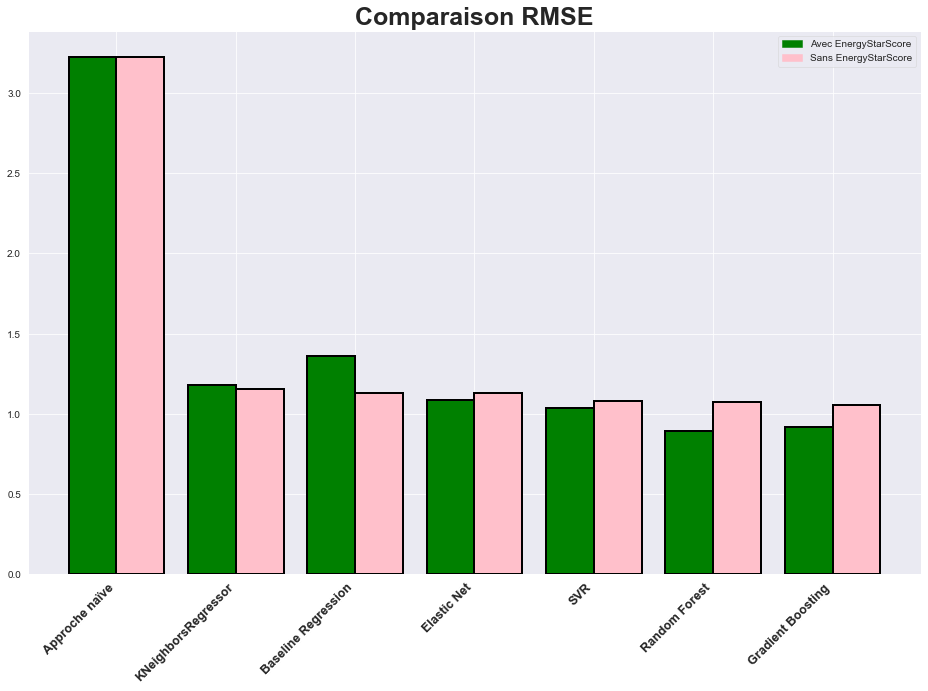

In [64]:
plt.figure(figsize=(16,10))

barWidth = 0.4

r1 = range(len(List_RMSE1))
r2 = [x + barWidth for x in r1]

plt.title("Comparaison RMSE", weight = 'bold',size=25)
plt.bar(r1, List_RMSE1, width = barWidth, color = 'green', linewidth = 2,edgecolor = 'black')
plt.bar(r2, List_RMSE2, width = barWidth, color = 'pink', linewidth = 2 ,edgecolor = 'black')

patch1 = mpatches.Patch(color='green', label='Avec EnergyStarScore')
patch2 = mpatches.Patch(color='pink', label='Sans EnergyStarScore')
plt.legend(handles=[patch1,patch2])

plt.xticks([r + barWidth / 2 for r in range(len(List_RMSE1))], List_model, size=12.5, rotation = 45, ha = 'right', weight = 'bold')

([<matplotlib.axis.XTick at 0x26612d736c8>,
 <a list of 7 Text xticklabel objects>)

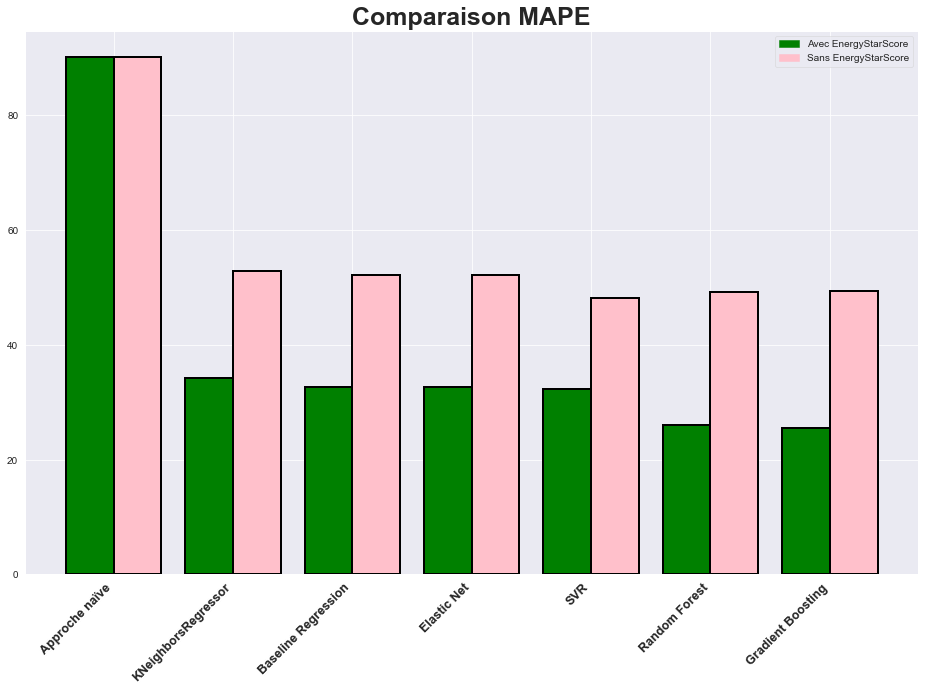

In [65]:
plt.figure(figsize=(16,10))

barWidth = 0.4

r1 = range(len(List_MAPE1))
r2 = [x + barWidth for x in r1]

plt.title("Comparaison MAPE", weight = 'bold',size=25)
plt.bar(r1, List_MAPE1, width = barWidth, color = 'green', linewidth = 2,edgecolor = 'black')
plt.bar(r2, List_MAPE2, width = barWidth, color = 'pink', linewidth = 2 ,edgecolor = 'black')

patch1 = mpatches.Patch(color='green', label='Avec EnergyStarScore')
patch2 = mpatches.Patch(color='pink', label='Sans EnergyStarScore')
plt.legend(handles=[patch1,patch2])

plt.xticks([r + barWidth / 2 for r in range(len(List_RMSE1))], List_model, size=12.5, rotation = 45, ha = 'right', weight = 'bold')

# Avec EnergyStarScore (Pour Target 2)

On rappelle que **Target 2** = **SiteEnergyUse(kBtu)**

### Approche naïve

In [66]:
# Création d'un vecteur de valeurs aléatoires comprises entre np.min(Y_train) et np.max(Y_train)
y_pred_random=[] 

for i in range(0,Y_test1.shape[0]):
    y = uniform(np.min(Y_train11), np.max(Y_train11))
    y_pred_random.append(y)

In [67]:
naive_error = np.sqrt(metrics.mean_squared_error(Y_test11, y_pred_random))
naive_mape = mean_absolute_percentage_error(Y_test11, y_pred_random)

print('RMSE :', naive_error)
print( 'MAPE : ', naive_mape)

List_RMSE1_target2.append(naive_error)
List_MAPE1_target2.append(naive_mape)

RMSE : 2.6604843681888335
MAPE :  15.037488025243842


### KNeighborsRegressor

In [68]:
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, {'n_neighbors' : list(range(1,30))}, cv = 5, scoring = 'neg_mean_squared_error')
grid.fit(X_train11_std, Y_train11)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [69]:
knn_error = np.sqrt(metrics.mean_squared_error(Y_test11, grid.best_estimator_.predict(X_test11_std)))
knn_mape =  mean_absolute_percentage_error(Y_test11, grid.best_estimator_.predict(X_test11_std))

print("RMSE (KNN):" , knn_error)
print("MAPE (KNN)" , knn_mape)

List_RMSE1_target2.append(knn_error)
List_MAPE1_target2.append(knn_mape)

RMSE (KNN): 0.9134533296111047
MAPE (KNN) 4.689495867349254


### Baseline Regression

In [70]:
linear = linear_model.LinearRegression()
linear.fit(X_train11_std,Y_train11)
baseline_error = np.mean(sklearn.model_selection.cross_val_score(linear, X_train11_std, Y_train11,cv=5,
                                                                 scoring = make_scorer(mean_squared_error)))

In [71]:
print( "Baseline error (RMSE) :",baseline_error)
print("Baseline error (MAPE) :", mean_absolute_percentage_error(Y_test11, linear.predict(X_test11_std)))

List_RMSE1_target2.append(baseline_error)
List_MAPE1_target2.append(mean_absolute_percentage_error(Y_test11, linear.predict(X_test11_std)))

Baseline error (RMSE) : 0.7014704350978151
Baseline error (MAPE) : 4.313074398739988


### Elastic Net 

In [72]:
elastic = linear_model.ElasticNet()
grid_elastic = GridSearchCV(elastic, {'alpha' : np.arange(0,10,1), 'l1_ratio' : np.arange(0,1,0.1) }, 
                            cv = 5, scoring = 'neg_mean_squared_error')
grid_elastic.fit(X_train11_std, Y_train11)

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.73879925827475, tolerance: 0.09713178150150764
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.73879925827475, tolerance: 0.09713178150150764
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\skl

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.31574511759467, tolerance: 0.0986901922982702
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\skle

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349.9523675783746, tolerance: 0.09713178150150764
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358.40842981303217, tolerance: 0.10121377254727859
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.8284214921, tolerance: 0.10187080283996963
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.0103598419806, tolerance: 0.09713178150150764
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 448.24518570841417, tolerance: 0.10121377254727859
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452.38328687864157, tolerance: 0.10187080283996963
  positive)
C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [73]:
elastic_error = np.sqrt(metrics.mean_squared_error(Y_test11, grid_elastic.best_estimator_.predict(X_test11_std)))
elastic_mape = mean_absolute_percentage_error(Y_test11,  grid_elastic.best_estimator_.predict(X_test11_std))

print("RMSE (ElasticNet) :", elastic_error)
print("MAPE(ElasticNet) :", elastic_mape)

List_RMSE1_target2.append(elastic_error)
List_MAPE1_target2.append(elastic_mape)

RMSE (ElasticNet) : 0.7939128825044103
MAPE(ElasticNet) : 4.313074398739988


### SVR 

In [74]:
svr = SVR()
grid3 = GridSearchCV(svr, {'C' : np.arange(1,100,5), 'epsilon' : np.arange(0,1,0.1) }, 
                     cv = 5, scoring= 'neg_mean_squared_error')
grid3.fit(X_train11_std, Y_train11)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
                         'epsilon': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [75]:
svr_error = np.sqrt(metrics.mean_squared_error(Y_test11, grid3.best_estimator_.predict(X_test11_std)))
svr_mape = mean_absolute_percentage_error(Y_test11,  grid3.best_estimator_.predict(X_test11_std))

print("RMSE (SVR) :" , svr_error)
print("MAPE (SVR) :", svr_mape)

List_RMSE1_target2.append(svr_error)
List_MAPE1_target2.append(svr_mape)

RMSE (SVR) : 0.6641236043450389
MAPE (SVR) : 3.386728375530748


### Random Forest

In [76]:
forest_regr = RandomForestRegressor()
grid4 = GridSearchCV(forest_regr, {'max_depth': range(3,7), 'n_estimators': (200, 300, 500, 600)}, 
        cv=5, scoring='neg_mean_squared_error', verbose=0)
grid4.fit(X_train11_std, Y_train11)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [77]:
forest_error = np.sqrt(metrics.mean_squared_error(Y_test11, grid4.best_estimator_.predict(X_test11_std)))
forest_mape = mean_absolute_percentage_error(Y_test11,  grid4.best_estimator_.predict(X_test11_std))

print("RMSE (SVR) :" , forest_error)
print("MAPE (SVR) :", forest_mape) 

List_RMSE1_target2.append(forest_error)
List_MAPE1_target2.append(forest_mape)

RMSE (SVR) : 0.5957049314925835
MAPE (SVR) : 3.0766366751444694


## Gradient Boosting

In [78]:
regressor = GradientBoostingRegressor()
grid5 = GridSearchCV(regressor, {'max_depth': range(4,7), 'n_estimators': (50, 60 , 80, 100),
                     'learning_rate': np.arange(0.05,0.5,0.05) }, cv=5, scoring='neg_mean_squared_error', verbose=0)
grid5.fit(X_train11_std,Y_train11)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [79]:
grid5.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}

In [80]:
boosting_error = np.sqrt(metrics.mean_squared_error(Y_test11, grid5.best_estimator_.predict(X_test11_std)))
boosting_mape = mean_absolute_percentage_error(Y_test11,  grid5.best_estimator_.predict(X_test11_std))


print("RMSE (SVR) :" , boosting_error)
print("MAPE (SVR) :", boosting_mape)

List_RMSE1_target2.append(boosting_error)
List_MAPE1_target2.append(boosting_mape)

RMSE (SVR) : 0.5988445027745597
MAPE (SVR) : 2.973651742621873


# Comparatif (Target 2)

([<matplotlib.axis.XTick at 0x26612b83508>,
 <a list of 7 Text xticklabel objects>)

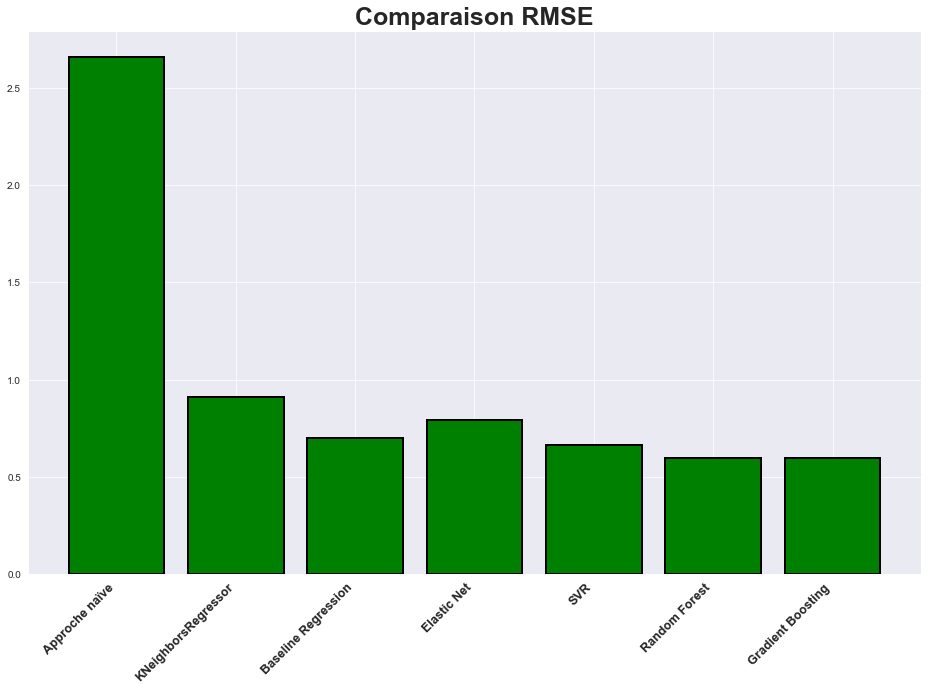

In [81]:
plt.figure(figsize=(16,10))

plt.title("Comparaison RMSE", weight = 'bold',size=25)
plt.bar(range(len(List_model)), List_RMSE1_target2, color = 'green', linewidth = 2,edgecolor = 'black')
plt.xticks(range(len(List_model)), List_model, size=12.5, rotation = 45, ha = 'right', weight = 'bold')

([<matplotlib.axis.XTick at 0x26612b40548>,
 <a list of 7 Text xticklabel objects>)

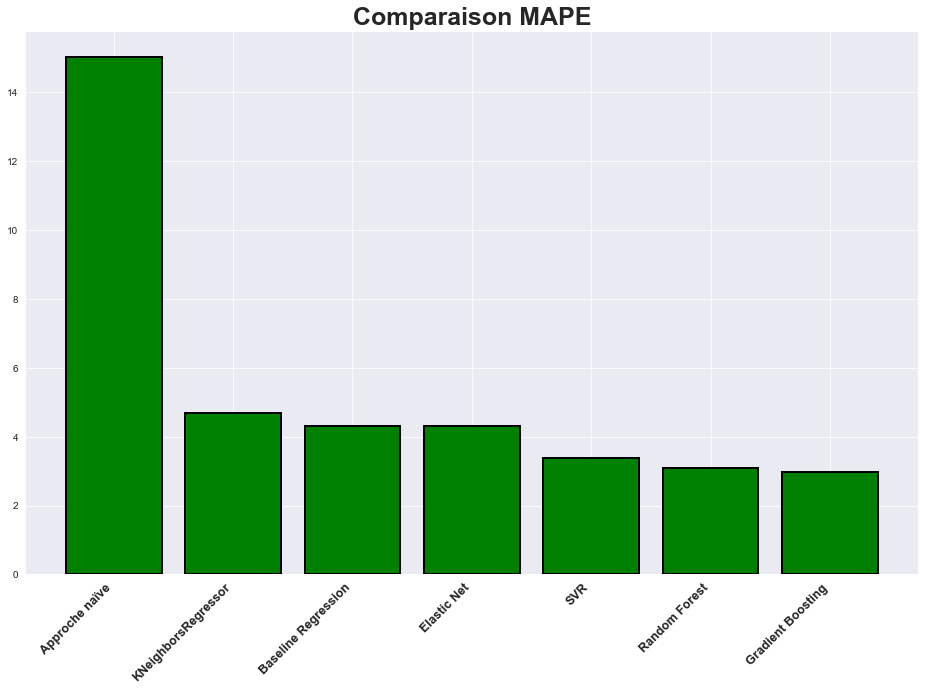

In [82]:
plt.figure(figsize=(16,10))

plt.title("Comparaison MAPE", weight = 'bold',size=25)
plt.bar(range(len(List_model)), List_MAPE1_target2, color = 'green', linewidth = 2,edgecolor = 'black')
plt.xticks(range(len(List_model)), List_model, size=12.5, rotation = 45, ha = 'right', weight = 'bold')

# Sélection de variables : méthode descendante

In [149]:
X_test1_std = pd.DataFrame(X_test1_std)
X_test1_std.columns = X_train1_std.columns
Liste_colonnes = list(X_train1_std.columns)

# Les blocs de variable.
neighborhood = ['MAGNOLIA / QUEEN ANNE','Others Neighborhood','DOWNTOWN','GREATER DUWAMISH','LAKE UNION' ]
building_type = ['Retail Store','Others BuildingType','Small- and Mid-Sized Office','Non-Refrigerated Warehouse','Large Office']
primary_property_type = ['NonResidential','Others PrimaryPropertyType']

In [143]:
def Descente(col):
    A=[]
    for i in range(len(col)):
        A.append(col[0:i]+col[(i+1):len(col)])
    return A

In [144]:
def Descente2(col1):

    RMSE = [] # Liste où on stock les RMSE.
    
    for j in Descente(col1):
        
        # Choix de l'algo.
        #boosting_regressor = GradientBoostingRegressor()
        
        knn = KNeighborsRegressor()
        grid5 = GridSearchCV(knn, {'n_neighbors' : list(range(3,20))}, cv = 5, scoring = 'neg_mean_squared_error')
        
        # GridSearch.
        #grid5 = GridSearchCV(boosting_regressor, {'max_depth': range(4,6), 'n_estimators': (50, 60 , 80),
                     #'learning_rate': np.arange(0.1,0.5,0.1) }, cv=5, scoring='neg_mean_squared_error')

        # Fitting sur le jeu d'entrainement réduit.
        grid5.fit(X_train1_std.loc[:,j],Y_train1)
        
        # Calcul de la RMSE.
        error = np.sqrt(metrics.mean_squared_error(Y_test1, grid5.best_estimator_.predict(X_test1_std.loc[:,j])))
        
        RMSE.append(error)
        
    return RMSE

In [139]:
# Méthode de descente prenant en compte les blocs de variables.

A = Descente2(Liste_colonnes) # Ensemble des features de départ
mini = [] # Liste qui contient les RMSE minimales
var = [] # Liste qui stock les variables enlevées lors de la descente

while (len(Liste_colonnes)>2):
    
    mini.append(min(A))
    variable_to_delete = Liste_colonnes[A.index(min(A))] # Variable à détruire.
    var.append(variable_to_delete)
     
    print(var)
                
    Liste_colonnes.remove(Liste_colonnes[A.index(min(A))])
    A = Descente2(Liste_colonnes)  

['Retail Store']
['Retail Store', 'Longitude']
['Retail Store', 'Longitude', 'YearBuilt']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore', 'Others PrimaryPropertyType']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore', 'Others PrimaryPropertyType', 'NumberofFloors']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore', 'Others PrimaryPropertyType', 'NumberofFloors', 'MAGNOLIA / QUEEN ANNE']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore', 'Others PrimaryPropertyType', 'NumberofFloors', 'MAGNOLIA / QUEEN ANNE', 'Others Neighborhood']
['Retail Store', 'Longitude', 'YearBuilt', 'Latitude', 'ENERGYSTARScore', 'Others PrimaryPropertyType', 'NumberofFloors', 'MAGNOLIA / QUEEN ANNE', 'Others Neighborhood', 'GREATER DUWAMISH']
['Retail Store', 'Longitude', 'YearBuilt', 'Lati

In [150]:
# Méthode de descente prenant en compte les blocs de variables.

A = Descente2(Liste_colonnes) # Ensemble des features de départ
mini = [] # Liste qui contient les RMSE minimales
var = [] # Liste qui stock les variables enlevées lors de la descente

while (len(Liste_colonnes)>2):
    
    mini.append(min(A))
    variable_to_delete = Liste_colonnes[A.index(min(A))] # Variable à détruire.
    var.append(variable_to_delete)
     
    print(var)
    
    # Check si la variable à détruire est dans un bloc.
    if (variable_to_delete in neighborhood):
        for j in neighborhood:
            Liste_colonnes.remove(j)
        A = Descente2(Liste_colonnes)  
    
    if (variable_to_delete in building_type):
        for j in building_type:
            Liste_colonnes.remove(j)
        A = Descente2(Liste_colonnes)  
            
    if (variable_to_delete in primary_property_type):
        for j in primary_property_type:
                Liste_colonnes.remove(j)
        A = Descente2(Liste_colonnes) 
                
    else:
        Liste_colonnes.remove(Liste_colonnes[A.index(min(A))])
        print(Liste_colonnes[A.index(min(A))])
        A = Descente2(Liste_colonnes)  
    print(Liste_colonnes)

['Retail Store']
NumberofFloors
['PropertyGFATotal', 'MAGNOLIA / QUEEN ANNE', 'GREATER DUWAMISH', 'NumberofFloors', 'YearBuilt', 'Longitude', 'NonResidential', 'Others Neighborhood', 'LAKE UNION', 'Latitude', 'DOWNTOWN', 'Others PrimaryPropertyType']
['Retail Store', 'YearBuilt']
Longitude
['PropertyGFATotal', 'MAGNOLIA / QUEEN ANNE', 'GREATER DUWAMISH', 'NumberofFloors', 'Longitude', 'NonResidential', 'Others Neighborhood', 'LAKE UNION', 'Latitude', 'DOWNTOWN', 'Others PrimaryPropertyType']
['Retail Store', 'YearBuilt', 'Longitude']
NonResidential
['PropertyGFATotal', 'MAGNOLIA / QUEEN ANNE', 'GREATER DUWAMISH', 'NumberofFloors', 'NonResidential', 'Others Neighborhood', 'LAKE UNION', 'Latitude', 'DOWNTOWN', 'Others PrimaryPropertyType']
['Retail Store', 'YearBuilt', 'Longitude', 'Latitude']
DOWNTOWN
['PropertyGFATotal', 'MAGNOLIA / QUEEN ANNE', 'GREATER DUWAMISH', 'NumberofFloors', 'NonResidential', 'Others Neighborhood', 'LAKE UNION', 'DOWNTOWN', 'Others PrimaryPropertyType']
['Retai

C:\Users\Louis\Anaconda3.1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: at least one array or dtype is required

  FitFailedWarning)


ValueError: at least one array or dtype is required

In [141]:
Liste_colonnes

['PropertyGFATotal', 'Non-Refrigerated Warehouse']

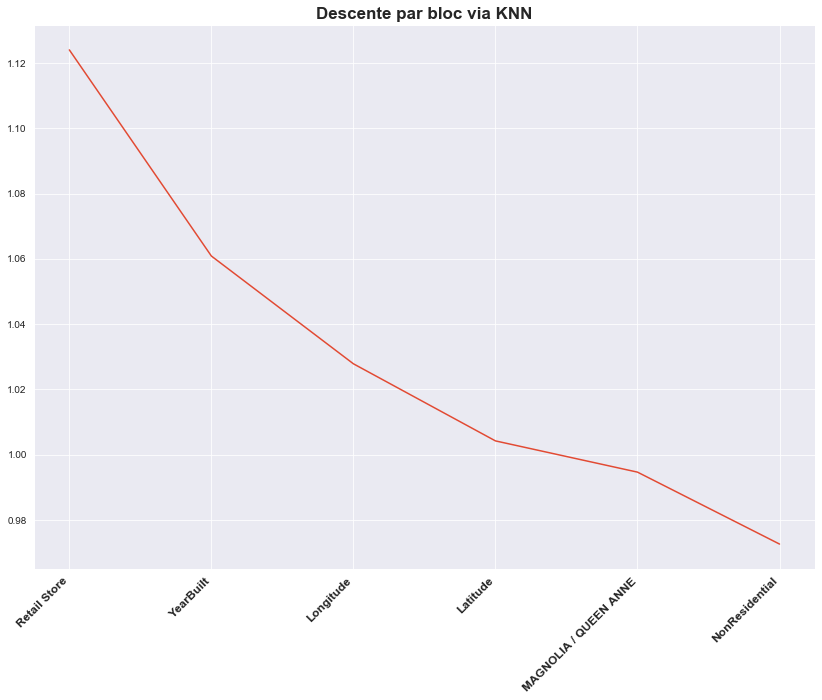

In [152]:
plt.figure(figsize=(14,10))
plt.title('Descente par bloc via KNN', size=17, weight ="bold")
plt.xticks(rotation=45, ha='right', weight='bold', size=12)
plt.plot(var,mini)

# Approche Bootstrap

Cette approche va nous permettre si elle est concluante d'avoir un certain degré de confiance dans nos prédicitons grâce à la stratégie bootstrap.

On cherche à créer **K>100** échantillon bootstrap à partir du training set (de target 2).
- **Algo retenu** : GBoost
- **Paramètres retenus** : **learning_rate** = 0.1, **max_depth** = 4, **n_estimator** = 60

In [ ]:
def variance(tableau):
    m = np.mean(tableau)
    return np.mean([(x-m)**2 for x in tableau])

In [ ]:
# Fonction renvoyant 100 échantillons bootstrap du training set.

sample_bootstrap_X = []
sample_bootstrap_Y = []

for j in range(100):
    df_X_courant = pd.DataFrame(np.zeros((748,18)), columns = X_train11_std.columns)
    df_Y_courant = []
    for i in range(748):
        a = randint(0,747)
        df_X_courant.iloc[i] = X_train11_std.iloc[a]
        df_Y_courant.append(np.array(Y_train11)[a])
    sample_bootstrap_X.append(df_X_courant)
    sample_bootstrap_Y.append(df_Y_courant)

In [ ]:
var.append(variance(pred))
mean.append(np.mean(pred))

In [ ]:
%%time

boosting_regressor = GradientBoostingRegressor(learning_rate = 0.1, max_depth= 4, n_estimators = 60)

Pred = []

for i in range(100):
    pred_boost = []
    boosting_regressor.fit(sample_bootstrap_X[i], sample_bootstrap_Y[i])
    for j in range(250):
        pred_boost.append(boosting_regressor.predict(X_test11_std[j].reshape(1, -1)))
    Pred.append(pred_boost)


In [ ]:
pred_tot = []

for i in range (250):
    a = []
    for j in range (100):
        a.append(Pred[j][i])
    pred_tot.append(a)

In [ ]:
var = [] # Liste qui va stocker les variances des prédictions.
mean = [] # Liste ou on stock les moyennes sur les prédictions.

for k in range(100):
    var.append(variance(pred_tot[k]))
    mean.append(np.mean(pred_tot[k]))

In [ ]:
ABS = []
Y = np.array(Y_test11)

for i,j in zip(mean,Y):
    ABS.append(abs(i - j))

In [ ]:
np.corrcoef(var, ABS)[0, 1]

In [ ]:
plt.figure(figsize = (16,9))
plt.title("Variance en fonction de l'erreur à la moyenne", weight = 'bold', size = 18)
axes = plt.gca()
axes.set_xlabel('Variance', size = 15, weight = 'bold')
axes.set_ylabel('Error', size = 15, weight = 'bold')
sns.scatterplot(var,ABS, color = 'blue')